In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
raw_df = pd.read_csv("data/mushrooms.csv")
data = raw_df[[column for column in raw_df.columns if column != "poisonous(target)"]].copy()
target = raw_df[["poisonous(target)"]].copy()
raw_df

,poisonous(target),cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [3]:
data.drop(columns=["veil-type"], inplace=True)

In [4]:
from tpnn.features import Encoder
data_encoder = Encoder("all", strategy='codes')
target_encoder = Encoder("all", strategy="onehot")

<Axes: >

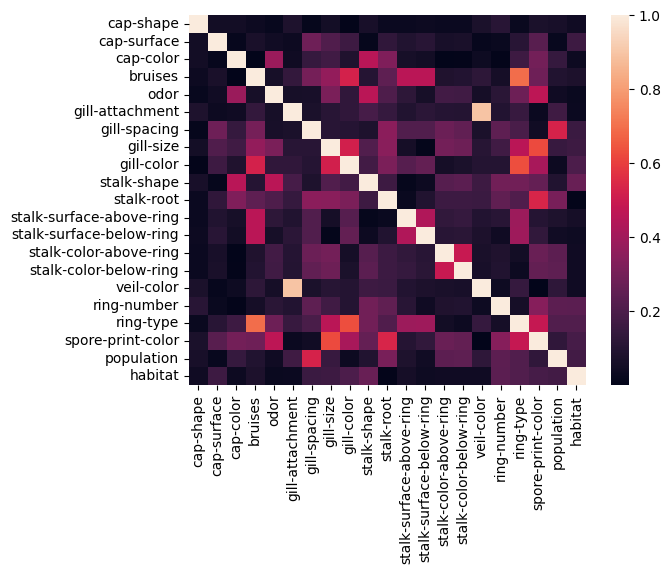

In [5]:
encoded_data = (data >> data_encoder)
sns.heatmap(encoded_data.corr().abs())

<Axes: >

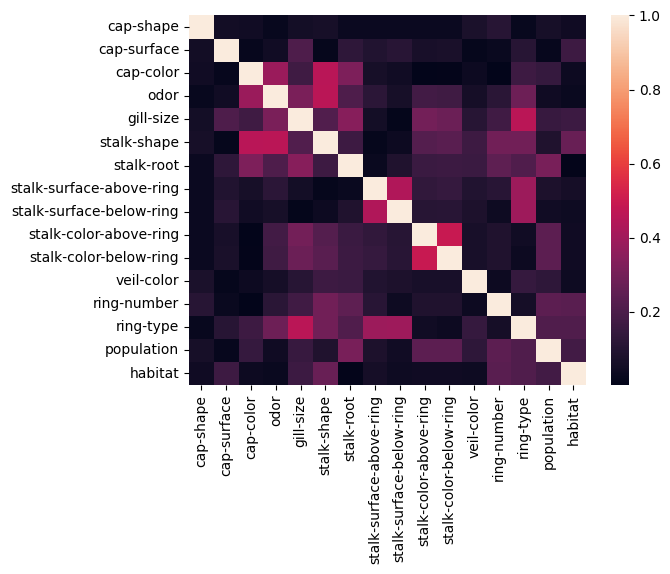

In [6]:
from tpnn.features import CorelationFilter

corr_filter = CorelationFilter(strategy='seq')
filtered_data = encoded_data >> corr_filter

sns.heatmap(filtered_data.corr().abs())

In [7]:
inputs = filtered_data.to_numpy()[:, np.newaxis, :]
inputs.shape

(8124, 1, 16)

In [8]:
outputs: np.ndarray = np.stack((target >> target_encoder).to_numpy()[:, 0])[:, np.newaxis, :]
outputs.shape

(8124, 1, 2)

In [9]:
from tpnn import train_test_split

x_train, y_train, x_test, y_test = train_test_split(inputs, outputs, random_state=1337)
print(f"{x_train.shape=}")
print(f"{y_train.shape=}")
print(f"{x_test.shape=}")
print(f"{y_test.shape=}")

x_train.shape=(6499, 1, 16)
y_train.shape=(6499, 1, 2)
x_test.shape=(1625, 1, 16)
y_test.shape=(1625, 1, 2)


In [40]:
from os.path import isfile
from tpnn.networks import Perceptron
from tpnn.core import set_lower_bound

if not isfile("nndumps/mushrooms_classification.nnsf"):
    set_lower_bound(0.0)
    model = Perceptron.from_dimensions((16, 64, 128, 2), loss='cross_entropy', activations=['tanh', 'tanh', 'softmax'])
    model.learn(x_train, y_train, learn_rate=0.1, momentum=0.5, epochs=100, batch_size=500)
    model.to_file("mushrooms_classification.nnsf")
else:
    model = Perceptron.from_file("mushrooms_classification.nnsf")

In [41]:
predicted_classes = np.where((x_test >> model)[:, :, 0] > 0.5, 0, 1).ravel()
np.unique(predicted_classes, return_counts=True)

(array([0, 1]), array([862, 763]))

In [37]:
target_classes = y_test[:, :, 1].ravel()
np.unique(target_classes, return_counts=True)

(array([0., 1.]), array([862, 763]))

In [42]:
from tpnn.metrics.classification import accuracy, precision, recall

print(
    f'accuracy:\t{accuracy(predicted_classes, target_classes):.6f}',
    f'precision:\t{precision(predicted_classes, target_classes):.6f}',
    f'accuracy:\t{recall(predicted_classes, target_classes):.6f}', 
    sep='\n',
)


accuracy:	0.998769
precision:	0.998765
accuracy:	0.998765


## ROC AUC кривая

<module 'matplotlib.pyplot' from '/Users/tjest/Desktop/vscode/labs/tpnn/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

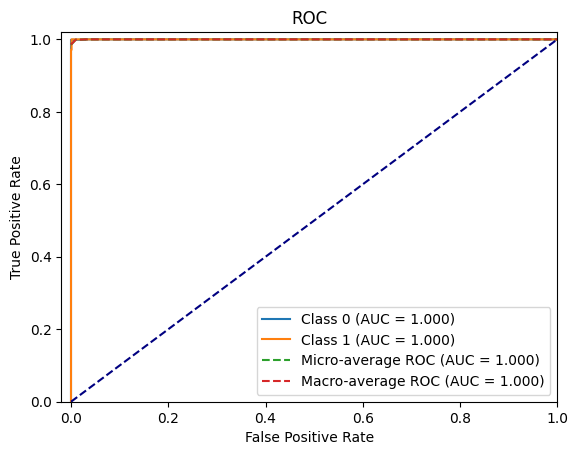

In [43]:
from tpnn.metrics.classification import roc_auc

roc_auc(x_test >> model, y_test)